## Assignment Requirements:

Interpret your models.

1. Fit a linear model and interpret the regression coefficients

2. Fit a tree-based model and interpret the nodes

3.  Use auto ml to find the best model

4. Run SHAP analysis on the models from steps 1, 2, and 3,   interpret the SHAP values and compare them with the other model interpretability methods.

 

Grading:  80% if meet the above requirements

Up to 20% for presentation and expanation.

 

Reference Notebook

https://github.com/ajhalthor/model-interpretability/blob/main/Shap%20Values.ipynb

## Abstract
According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths. So this notebook is used to predict whether or not an individual will suffer a stroke. First, I will perform extensive data visualization. This will help me to see if there are any features that look to be indicative of a stroke, or indeed of not having a stroke. Next, I will build multiple models and select the best performing one. Finally, I will dive into model interpretation and use shap analysis to achieve this.

Here is the dataset and attribute information.
- id: unique identifier
- gender: "Male", "Female" or "Other"
- age: age of the patient
- hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
- heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
- ever_married: "No" or "Yes"
- work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
- Residence_type: "Rural" or "Urban"
- avg_glucose_level: average glucose level in blood
- bmi: body mass index
- smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
- stroke: 1 if the patient had a stroke or 0 if not
*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

## Import Library and Processing Data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.gridspec as grid_spec
import seaborn as sns
from imblearn.over_sampling import SMOTE
import scikitplot as skplt


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score


from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, f1_score
import warnings
warnings.filterwarnings('ignore')
!pip install pywaffle

/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv
     |████████████████████████████████| 25.1 MB 7.1 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
df = pd.read_csv('/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')
df.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
##Missing Data
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

### Blanks Data Processing

There are many ways. One can simply drop these records, fill the blanks with the mean, the median, or even simply the record before or after the missing value.

But there are other, more unusual ways. 

Here I will use a **Decision Tree to predict the missing BMI**

Other interesting methods to explore could include using K-Nearest-Neighbours to fill the gaps.

In [4]:
# A really fantsatic and intelligent way to deal with blanks, from Thoman Konstantin in: https://www.kaggle.com/thomaskonstantin/analyzing-and-modeling-stroke-data

DT_bmi_pipe = Pipeline( steps=[ 
                               ('scale',StandardScaler()),
                               ('lr',DecisionTreeRegressor(random_state=42))
                              ])
X = df[['age','gender','bmi']].copy()
X.gender = X.gender.replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)

Missing = X[X.bmi.isna()]
X = X[~X.bmi.isna()]
Y = X.pop('bmi')
DT_bmi_pipe.fit(X,Y)
predicted_bmi = pd.Series(DT_bmi_pipe.predict(Missing[['age','gender']]),index=Missing.index)
df.loc[Missing.index,'bmi'] = predicted_bmi

In [5]:
print('Missing values: ',sum(df.isnull().sum()))

Missing values:  0


We've replaced all missing values.

Now we can move to the next step: Exploring Data.

## Exploring the data

We have dealt with the missing values in the data.

Next, I want to explore the data.

Does age makes one more likely to suffer a stroke? What about gender? Or BMI?

These are all questions that can be explored and answered with some data visulization. 

First, let's look at the numeric/continuous variable distribtion.

In [6]:
variables = [variable for variable in df.columns if variable not in ['id','stroke']]

conts = ['age','avg_glucose_level','bmi']

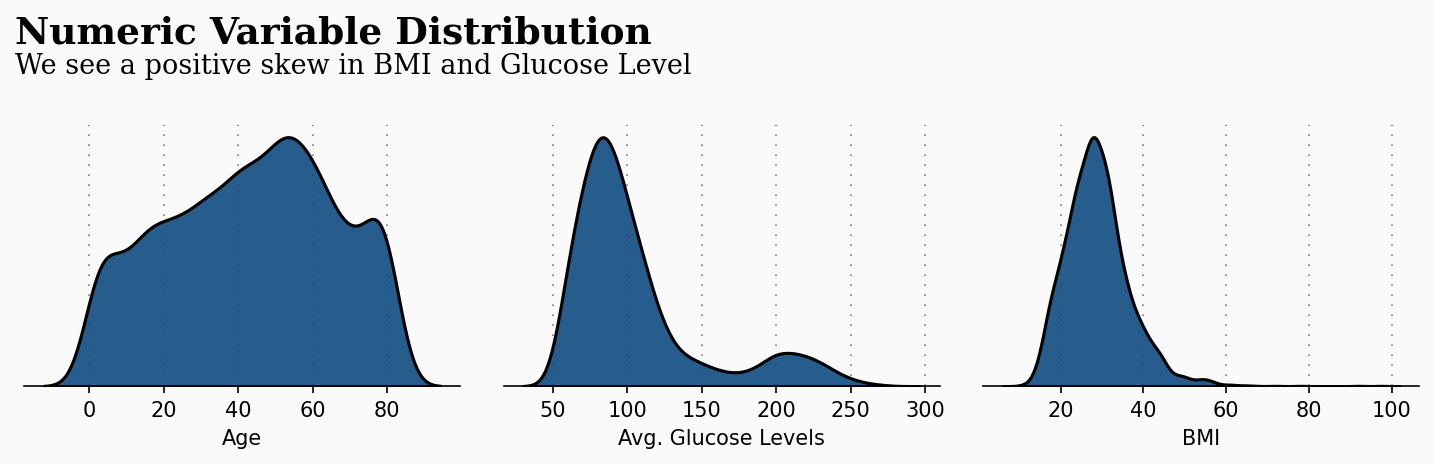

In [7]:
fig = plt.figure(figsize=(12, 12), dpi=150, facecolor='#fafafa')
gs = fig.add_gridspec(4, 3)
gs.update(wspace=0.1, hspace=0.4)

background_color = "#fafafa"

plot = 0
for row in range(0, 1):
    for col in range(0, 3):
        locals()["ax"+str(plot)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(plot)].set_facecolor(background_color)
        locals()["ax"+str(plot)].tick_params(axis='y', left=False)
        locals()["ax"+str(plot)].get_yaxis().set_visible(False)
        for s in ["top","right","left"]:
            locals()["ax"+str(plot)].spines[s].set_visible(False)
        plot += 1

plot = 0
for variable in conts:
        sns.kdeplot(df[variable] ,ax=locals()["ax"+str(plot)], color='#0f4c81', shade=True, linewidth=1.5, ec='black',alpha=0.9, zorder=3, legend=False)
        locals()["ax"+str(plot)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
        #locals()["ax"+str(plot)].set_xlabel(variable) removed this for aesthetics
        plot += 1
        
ax0.set_xlabel('Age')
ax1.set_xlabel('Avg. Glucose Levels')
ax2.set_xlabel('BMI')


ax0.text(-20, 0.022, 'Numeric Variable Distribution', fontsize=18, fontweight='bold', fontfamily='serif')
ax0.text(-20, 0.02, 'We see a positive skew in BMI and Glucose Level', fontsize=13, fontweight='light', fontfamily='serif')

plt.show()

So we've gained some understanding on the distributiona of our numeric variables, but we can add more information to this plot. 

Let's see how the distribution of our numeric variables is different for **those that have strokes, and those that do not.**

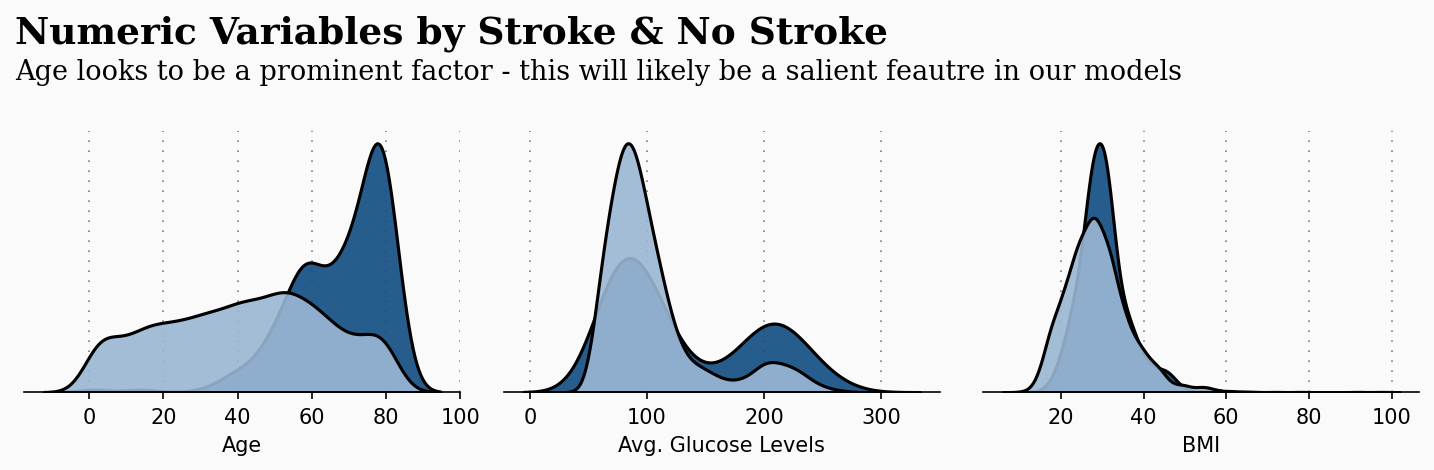

In [8]:
fig = plt.figure(figsize=(12, 12), dpi=150,facecolor=background_color)
gs = fig.add_gridspec(4, 3)
gs.update(wspace=0.1, hspace=0.4)


plot = 0
for row in range(0, 1):
    for col in range(0, 3):
        locals()["ax"+str(plot)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(plot)].set_facecolor(background_color)
        locals()["ax"+str(plot)].tick_params(axis='y', left=False)
        locals()["ax"+str(plot)].get_yaxis().set_visible(False)
        for s in ["top","right","left"]:
            locals()["ax"+str(plot)].spines[s].set_visible(False)
        plot += 1

plot = 0

s = df[df['stroke'] == 1]
ns = df[df['stroke'] == 0]

for feature in conts:
        sns.kdeplot(s[feature], ax=locals()["ax"+str(plot)], color='#0f4c81', shade=True, linewidth=1.5, ec='black',alpha=0.9, zorder=3, legend=False)
        sns.kdeplot(ns[feature],ax=locals()["ax"+str(plot)], color='#9bb7d4', shade=True, linewidth=1.5, ec='black',alpha=0.9, zorder=3, legend=False)
        locals()["ax"+str(plot)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
        #locals()["ax"+str(plot)].set_xlabel(feature)
        plot += 1

ax0.set_xlabel('Age')
ax1.set_xlabel('Avg. Glucose Levels')
ax2.set_xlabel('BMI')
        
ax0.text(-20, 0.056, 'Numeric Variables by Stroke & No Stroke', fontsize=18, fontweight='bold', fontfamily='serif')
ax0.text(-20, 0.05, 'Age looks to be a prominent factor - this will likely be a salient feautre in our models', 
         fontsize=13, fontweight='light', fontfamily='serif')

plt.show()



Based on the above plots, it seems clear that **Age is a big factor** in stroke patients - the older you get the more at risk you are.

Though less obvious, there are also differences in Avg. Glucose Levels and BMI.


In [9]:
str_only = df[df['stroke'] == 1]
no_str_only = df[df['stroke'] == 0]

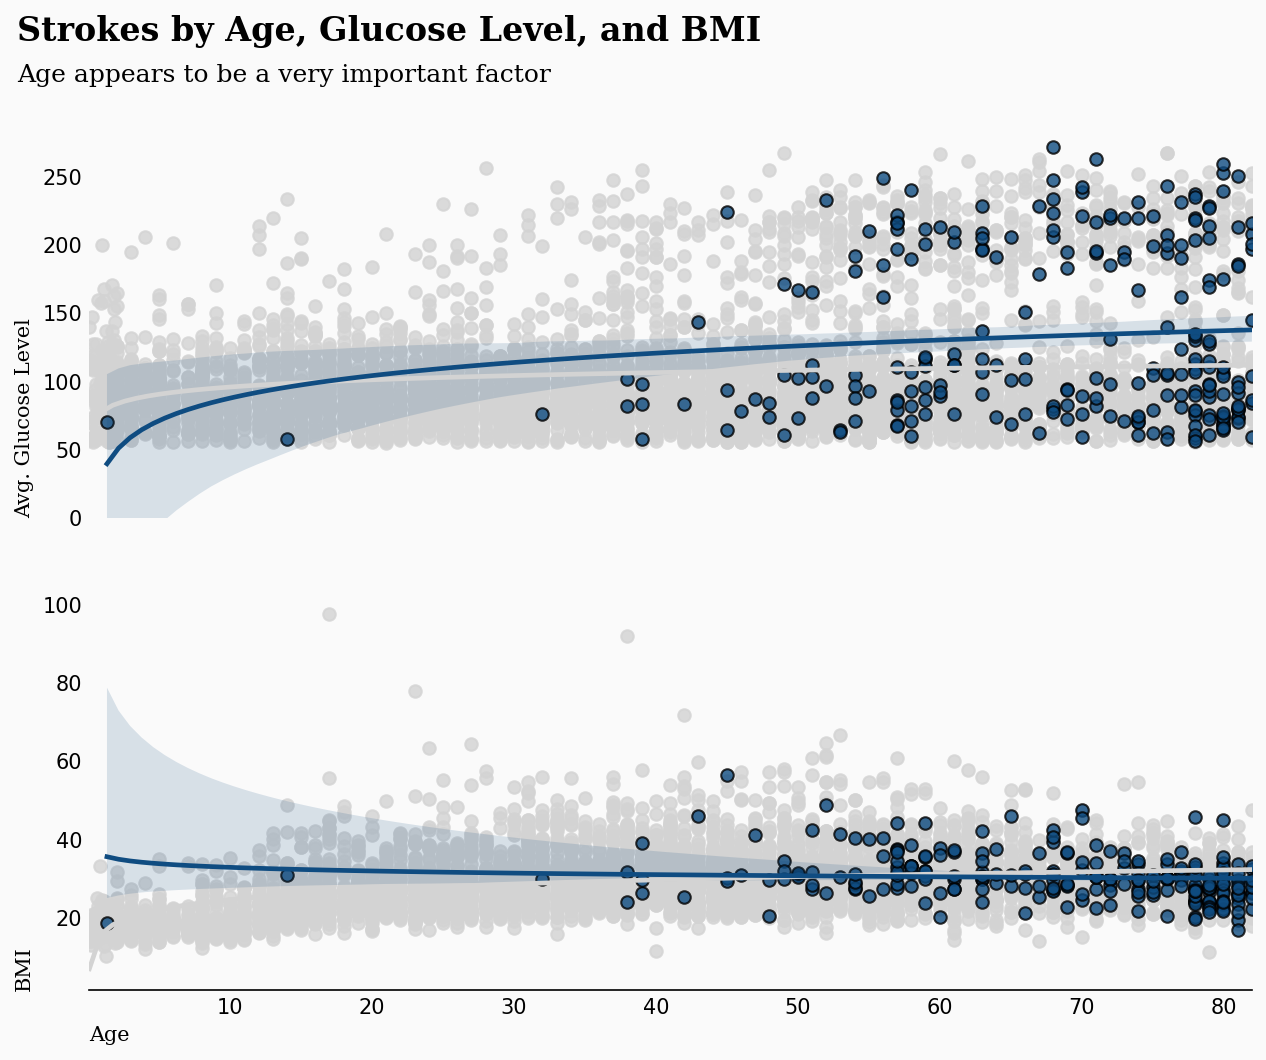

In [10]:
# Setting up figure and axes

fig = plt.figure(figsize=(10,16),dpi=150,facecolor=background_color) 
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.5, hspace=0.2)
ax0 = fig.add_subplot(gs[0, 0:2])
ax1 = fig.add_subplot(gs[1, 0:2]) 

ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)

# glucose

sns.regplot(no_str_only['age'],y=no_str_only['avg_glucose_level'],  
            color='lightgray',
            logx=True,
            ax=ax0)

sns.regplot(str_only['age'],y=str_only['avg_glucose_level'],  
            color='#0f4c81',
            logx=True,scatter_kws={'edgecolors':['black'], 
                                              'linewidth': 1},
            ax=ax0)

ax0.set(ylim=(0, None))
ax0.set_xlabel(" ",fontsize=12,fontfamily='serif')
ax0.set_ylabel("Avg. Glucose Level",fontsize=10,fontfamily='serif',loc='bottom')

ax0.tick_params(axis='x', bottom=False)
ax0.get_xaxis().set_visible(False)

for s in ['top','left','bottom']:
    ax0.spines[s].set_visible(False)


# bmi
sns.regplot(no_str_only['age'],y=no_str_only['bmi'],  
            color='lightgray',
            logx=True,
            ax=ax1)

sns.regplot(str_only['age'],y=str_only['bmi'],  
            color='#0f4c81', scatter_kws={'edgecolors':['black'], 
                                              'linewidth': 1},
            logx=True,
            ax=ax1)

ax1.set_xlabel("Age",fontsize=10,fontfamily='serif',loc='left')
ax1.set_ylabel("BMI",fontsize=10,fontfamily='serif',loc='bottom')


for s in ['top','left','right']:
    ax0.spines[s].set_visible(False)
    ax1.spines[s].set_visible(False)

    
ax0.text(-5,350,'Strokes by Age, Glucose Level, and BMI',fontsize=16,fontfamily='serif',fontweight='bold')
ax0.text(-5,320,'Age appears to be a very important factor',fontsize=12,fontfamily='serif')


ax0.tick_params(axis=u'both', which=u'both',length=0)
ax1.tick_params(axis=u'both', which=u'both',length=0)



plt.show()

As we suspected, Age is a big factor, and also has slight relationships with BMI & Avg. Glucose levels.

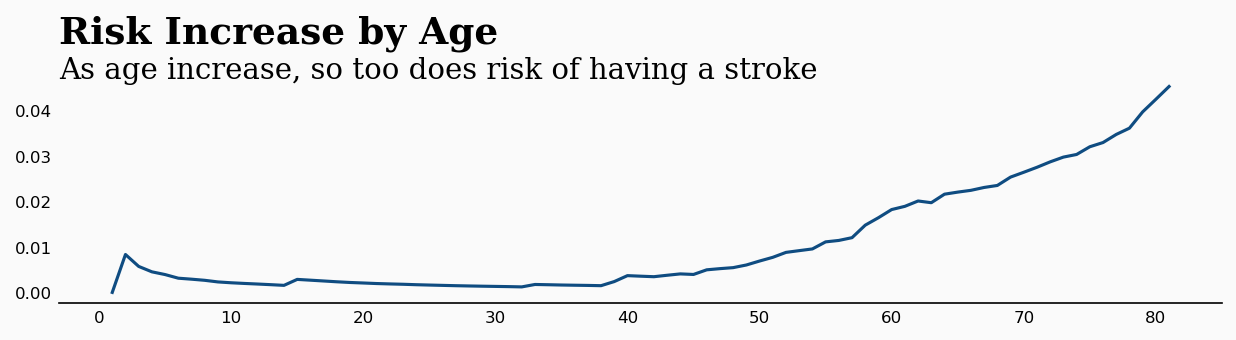

In [11]:
##We might understand intuitively that as Age increases, the risk of having a stroke increases. Therefore, we can visualise this graph.
fig = plt.figure(figsize=(10, 5), dpi=150,facecolor=background_color)
gs = fig.add_gridspec(2, 1)
gs.update(wspace=0.11, hspace=0.5)
ax0 = fig.add_subplot(gs[0, 0])
ax0.set_facecolor(background_color)


df['age'] = df['age'].astype(int)

rate = []
for i in range(df['age'].min(), df['age'].max()):
    rate.append(df[df['age'] < i]['stroke'].sum() / len(df[df['age'] < i]['stroke']))

sns.lineplot(data=rate,color='#0f4c81',ax=ax0)

for s in ["top","right","left"]:
    ax0.spines[s].set_visible(False)

ax0.tick_params(axis='both', which='major', labelsize=8)
ax0.tick_params(axis=u'both', which=u'both',length=0)

ax0.text(-3,0.055,'Risk Increase by Age',fontsize=18,fontfamily='serif',fontweight='bold')
ax0.text(-3,0.047,'As age increase, so too does risk of having a stroke',fontsize=14,fontfamily='serif')


plt.show()

This confirms what our intuitions told us. The older you get, the more at risk you get.

However, you may have notices the low risk values on the y-axis. This is because the **dataset is highly imbalanced**.

Only 249 strokes are in our dataset which totals 5000 - around 1 in 20. 

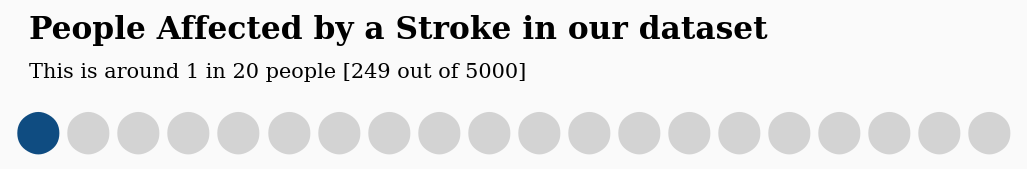

In [12]:
from pywaffle import Waffle

fig = plt.figure(figsize=(7, 2),dpi=150,facecolor=background_color,
    FigureClass=Waffle,
    rows=1,
    values=[1, 19],
    colors=['#0f4c81', "lightgray"],
    characters='⬤',
    font_size=20,vertical=True,
)

fig.text(0.035,0.78,'People Affected by a Stroke in our dataset',fontfamily='serif',fontsize=15,fontweight='bold')
fig.text(0.035,0.65,'This is around 1 in 20 people [249 out of 5000]',fontfamily='serif',fontsize=10)

plt.show()

This needs to be considered when modelling of course, but also when formulating risk.

Strokes are still relatively rare, we are not saying anything is guaranteed, just that risk is increasing.

In [13]:
# Drop single 'Other' gender
no_str_only = no_str_only[(no_str_only['gender'] != 'Other')]


We've assessed a few variables so far, and gained some powerful insights. 

I'll now plot several variables in one place, so we can spot interesting trends or features.

I will split the data in to 'Stroke' and 'No-Stroke' so we can see if these two populations differ in any meaningful way.

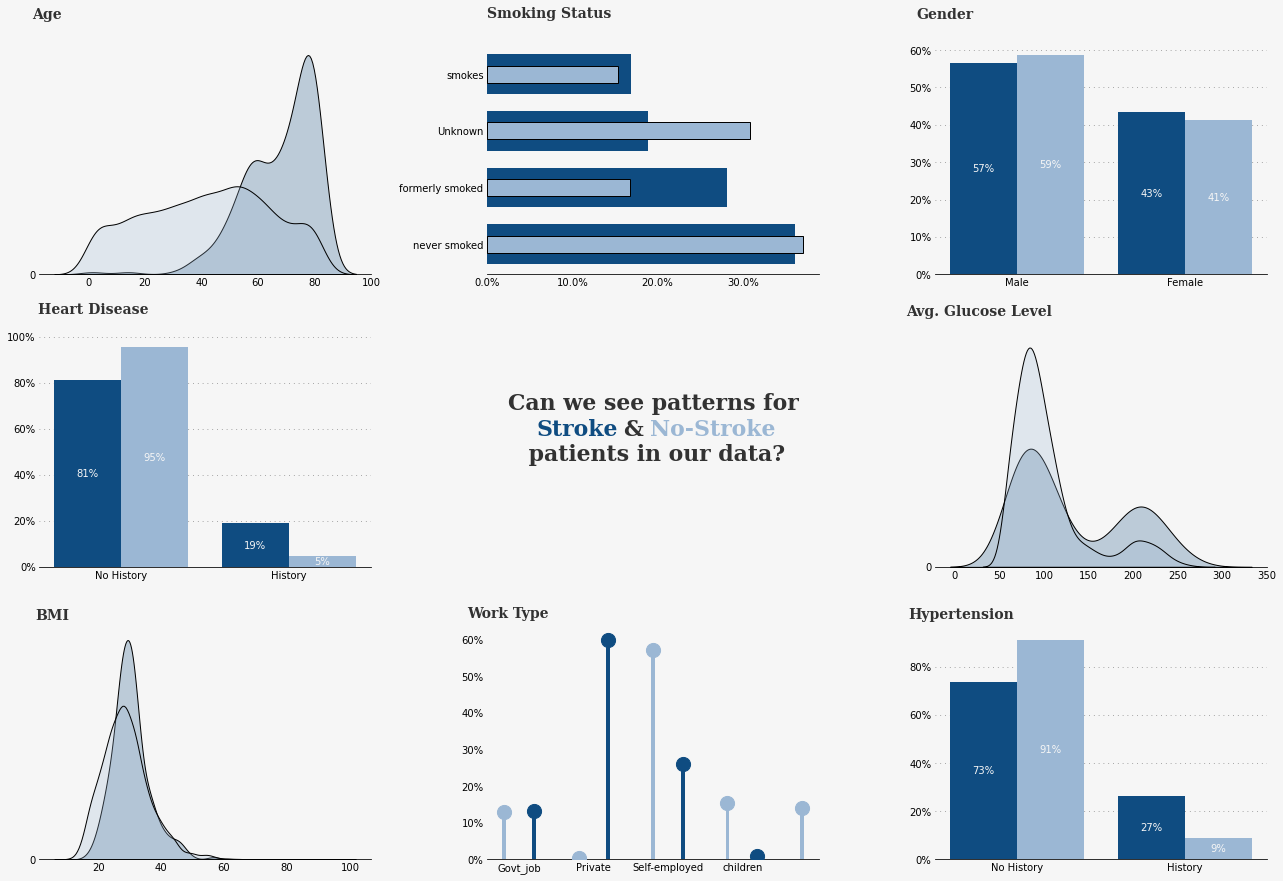

In [14]:
fig = plt.figure(figsize=(22,15))
gs = fig.add_gridspec(3, 3)
gs.update(wspace=0.35, hspace=0.27)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[1, 2])
ax6 = fig.add_subplot(gs[2, 0])
ax7 = fig.add_subplot(gs[2, 1])
ax8 = fig.add_subplot(gs[2, 2])

background_color = "#f6f6f6"
fig.patch.set_facecolor(background_color) # figure background color


# Plots

## Age
ax0.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
positive = pd.DataFrame(str_only["age"])
negative = pd.DataFrame(no_str_only["age"])
sns.kdeplot(positive["age"], ax=ax0,color="#0f4c81", shade=True, ec='black',label="positive")
sns.kdeplot(negative["age"], ax=ax0, color="#9bb7d4", shade=True, ec='black',label="negative")
#ax3.text(0.29, 13, 'Age', 
 #        fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax0.yaxis.set_major_locator(mtick.MultipleLocator(2))
ax0.set_ylabel('')    
ax0.set_xlabel('')
ax0.text(-20, 0.0465, 'Age', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")


# Smoking
positive = pd.DataFrame(str_only["smoking_status"].value_counts())
positive["Percentage"] = positive["smoking_status"].apply(lambda x: x/sum(positive["smoking_status"])*100)
negative = pd.DataFrame(no_str_only["smoking_status"].value_counts())
negative["Percentage"] = negative["smoking_status"].apply(lambda x: x/sum(negative["smoking_status"])*100)

ax1.text(0, 4, 'Smoking Status', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax1.barh(positive.index, positive['Percentage'], color="#0f4c81", zorder=3, height=0.7)
ax1.barh(negative.index, negative['Percentage'], color="#9bb7d4", zorder=3,ec='black', height=0.3)
ax1.xaxis.set_major_formatter(mtick.PercentFormatter())
ax1.xaxis.set_major_locator(mtick.MultipleLocator(10))

##
# Ax2 - GENDER 
positive = pd.DataFrame(str_only["gender"].value_counts())
positive["Percentage"] = positive["gender"].apply(lambda x: x/sum(positive["gender"])*100)
negative = pd.DataFrame(no_str_only["gender"].value_counts())
negative["Percentage"] = negative["gender"].apply(lambda x: x/sum(negative["gender"])*100)

x = np.arange(len(positive))
ax2.text(-0.4, 68.5, 'Gender', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax2.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax2.bar(x, height=positive["Percentage"], zorder=3, color="#0f4c81", width=0.4)
ax2.bar(x+0.4, height=negative["Percentage"], zorder=3, color="#9bb7d4", width=0.4)
ax2.set_xticks(x + 0.4 / 2)
ax2.set_xticklabels(['Male','Female'])
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.yaxis.set_major_locator(mtick.MultipleLocator(10))
for i,j in zip([0, 1], positive["Percentage"]):
    ax2.annotate(f'{j:0.0f}%',xy=(i, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')
for i,j in zip([0, 1], negative["Percentage"]):
    ax2.annotate(f'{j:0.0f}%',xy=(i+0.4, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')

    

# Heart Dis

positive = pd.DataFrame(str_only["heart_disease"].value_counts())
positive["Percentage"] = positive["heart_disease"].apply(lambda x: x/sum(positive["heart_disease"])*100)
negative = pd.DataFrame(no_str_only["heart_disease"].value_counts())
negative["Percentage"] = negative["heart_disease"].apply(lambda x: x/sum(negative["heart_disease"])*100)

x = np.arange(len(positive))
ax3.text(-0.3, 110, 'Heart Disease', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax3.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax3.bar(x, height=positive["Percentage"], zorder=3, color="#0f4c81", width=0.4)
ax3.bar(x+0.4, height=negative["Percentage"], zorder=3, color="#9bb7d4", width=0.4)
ax3.set_xticks(x + 0.4 / 2)
ax3.set_xticklabels(['No History','History'])
ax3.yaxis.set_major_formatter(mtick.PercentFormatter())
ax3.yaxis.set_major_locator(mtick.MultipleLocator(20))
for i,j in zip([0, 1], positive["Percentage"]):
    ax3.annotate(f'{j:0.0f}%',xy=(i, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')
for i,j in zip([0, 1], negative["Percentage"]):
    ax3.annotate(f'{j:0.0f}%',xy=(i+0.4, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')
    

## AX4 - TITLE

ax4.spines["bottom"].set_visible(False)
ax4.tick_params(left=False, bottom=False)
ax4.set_xticklabels([])
ax4.set_yticklabels([])
ax4.text(0.5, 0.6, 'Can we see patterns for\n\n patients in our data?', horizontalalignment='center', verticalalignment='center',
         fontsize=22, fontweight='bold', fontfamily='serif', color="#323232")

ax4.text(0.15,0.57,"Stroke", fontweight="bold", fontfamily='serif', fontsize=22, color='#0f4c81')
ax4.text(0.41,0.57,"&", fontweight="bold", fontfamily='serif', fontsize=22, color='#323232')
ax4.text(0.49,0.57,"No-Stroke", fontweight="bold", fontfamily='serif', fontsize=22, color='#9bb7d4')


# Glucose

ax5.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
positive = pd.DataFrame(str_only["avg_glucose_level"])
negative = pd.DataFrame(no_str_only["avg_glucose_level"])
sns.kdeplot(positive["avg_glucose_level"], ax=ax5,color="#0f4c81",ec='black', shade=True, label="positive")
sns.kdeplot(negative["avg_glucose_level"], ax=ax5, color="#9bb7d4", ec='black',shade=True, label="negative")
ax5.text(-55, 0.01855, 'Avg. Glucose Level', 
         fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax5.yaxis.set_major_locator(mtick.MultipleLocator(2))
ax5.set_ylabel('')    
ax5.set_xlabel('')



## BMI


ax6.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
positive = pd.DataFrame(str_only["bmi"])
negative = pd.DataFrame(no_str_only["bmi"])
sns.kdeplot(positive["bmi"], ax=ax6,color="#0f4c81", ec='black',shade=True, label="positive")
sns.kdeplot(negative["bmi"], ax=ax6, color="#9bb7d4",ec='black', shade=True, label="negative")
ax6.text(-0.06, 0.09, 'BMI', 
         fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax6.yaxis.set_major_locator(mtick.MultipleLocator(2))
ax6.set_ylabel('')    
ax6.set_xlabel('')


# Work Type

positive = pd.DataFrame(str_only["work_type"].value_counts())
positive["Percentage"] = positive["work_type"].apply(lambda x: x/sum(positive["work_type"])*100)
positive = positive.sort_index()

negative = pd.DataFrame(no_str_only["work_type"].value_counts())
negative["Percentage"] = negative["work_type"].apply(lambda x: x/sum(negative["work_type"])*100)
negative = negative.sort_index()

ax7.bar(negative.index, height=negative["Percentage"], zorder=3, color="#9bb7d4", width=0.05)
ax7.scatter(negative.index, negative["Percentage"], zorder=3,s=200, color="#9bb7d4")
ax7.bar(np.arange(len(positive.index))+0.4, height=positive["Percentage"], zorder=3, color="#0f4c81", width=0.05)
ax7.scatter(np.arange(len(positive.index))+0.4, positive["Percentage"], zorder=3,s=200, color="#0f4c81")

ax7.yaxis.set_major_formatter(mtick.PercentFormatter())
ax7.yaxis.set_major_locator(mtick.MultipleLocator(10))
ax7.set_xticks(np.arange(len(positive.index))+0.4 / 2)
ax7.set_xticklabels(list(positive.index),rotation=0)
ax7.text(-0.5, 66, 'Work Type', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")



# hypertension

positive = pd.DataFrame(str_only["hypertension"].value_counts())
positive["Percentage"] = positive["hypertension"].apply(lambda x: x/sum(positive["hypertension"])*100)
negative = pd.DataFrame(no_str_only["hypertension"].value_counts())
negative["Percentage"] = negative["hypertension"].apply(lambda x: x/sum(negative["hypertension"])*100)

x = np.arange(len(positive))
ax8.text(-0.45, 100, 'Hypertension', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax8.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax8.bar(x, height=positive["Percentage"], zorder=3, color="#0f4c81", width=0.4)
ax8.bar(x+0.4, height=negative["Percentage"], zorder=3, color="#9bb7d4", width=0.4)
ax8.set_xticks(x + 0.4 / 2)
ax8.set_xticklabels(['No History','History'])
ax8.yaxis.set_major_formatter(mtick.PercentFormatter())
ax8.yaxis.set_major_locator(mtick.MultipleLocator(20))
for i,j in zip([0, 1], positive["Percentage"]):
    ax8.annotate(f'{j:0.0f}%',xy=(i, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')
for i,j in zip([0, 1], negative["Percentage"]):
    ax8.annotate(f'{j:0.0f}%',xy=(i+0.4, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')


# tidy up



for s in ["top","right","left"]:
    for i in range(0,9):
        locals()["ax"+str(i)].spines[s].set_visible(False)
        
for i in range(0,9):
        locals()["ax"+str(i)].set_facecolor(background_color)
        locals()["ax"+str(i)].tick_params(axis=u'both', which=u'both',length=0)
        locals()["ax"+str(i)].set_facecolor(background_color) 

        
plt.show()

As discussed earlier, we again note the importance of Age, amongst other things.

## Model Preparation

In [15]:
# Encoding categorical values

df['gender'] = df['gender'].replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)
df['Residence_type'] = df['Residence_type'].replace({'Rural':0,'Urban':1}).astype(np.uint8)
df['work_type'] = df['work_type'].replace({'Private':0,'Self-employed':1,'Govt_job':2,'children':-1,'Never_worked':-2}).astype(np.uint8)

Can we predict whether or not an indiviudal will suffer a stroke?

First, I will use the SMOTE (Synthetic Minority Over-sampling Technique) to balance our dataset.

Currently, as I mentioned above, there are many more negative examples of a stroke and this could hinder our model.

This can be addressed using SMOTE.

### Baseline

For such an imbalanced dataset, a useful baseline can be to beat the 'Null Accuracy', and in our case, since we're looking for the positive ('stroke'), I will take the inverse of that.
In other words, always predicting the most common outcome. 

For this case, 249/(249+4861) = 0.048

So a good target to beat would be 5%~ for recall for positive stroke patients.

In [16]:
# Inverse of Null Accuracy
print('Inverse of Null Accuracy: ',249/(249+4861))
print('Null Accuracy: ',4861/(4861+249))

Inverse of Null Accuracy:  0.0487279843444227
Null Accuracy:  0.9512720156555773


In [17]:
X  = df[['gender','age','hypertension','heart_disease','work_type','avg_glucose_level','bmi']]
y = df['stroke']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.3, random_state=42)

In [18]:
X_test.head(5)

,gender,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi
4688,0,31,0,0,1,64.85,23.0
4478,0,40,0,0,1,65.29,28.3
3849,1,8,0,0,255,74.42,22.5
4355,1,79,1,0,1,76.64,19.5
3826,1,75,0,0,2,94.77,27.2


In [19]:
# Our data is biased, we can fix this with SMOTE

oversample = SMOTE()
X_train_resh, y_train_resh = oversample.fit_resample(X_train, y_train.ravel())

Now our data is equal.

## Training models in Random Forest, SVM, and Logisitc Regression



I will utilize 10 fold cross validation.

In [20]:
# Models

# Scale our data in pipeline, then split

rf_pipeline = Pipeline(steps = [('scale',StandardScaler()),('RF',RandomForestClassifier(random_state=42))])
svm_pipeline = Pipeline(steps = [('scale',StandardScaler()),('SVM',SVC(random_state=42))])
logreg_pipeline = Pipeline(steps = [('scale',StandardScaler()),('LR',LogisticRegression(random_state=42))])



#X = upsampled_df.iloc[:,:-1] # X_train_resh
#Y = upsampled_df.iloc[:,-1]# y_train_resh

#retain_x = X.sample(100)
#retain_y = Y.loc[X.index]

#X = X.drop(index=retain_x.index)
#Y = Y.drop(index=retain_x.index)

In [21]:
rf_cv = cross_val_score(rf_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1')
svm_cv = cross_val_score(svm_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1')
logreg_cv = cross_val_score(logreg_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1')

In [22]:
print('Mean f1 scores:')
print('Random Forest mean :',cross_val_score(rf_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1').mean())
print('SVM mean :',cross_val_score(svm_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1').mean())
print('Logistic Regression mean :',cross_val_score(logreg_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1').mean())



Mean f1 scores:
Random Forest mean : 0.936448680324444
SVM mean : 0.8780988719157742
Logistic Regression mean : 0.8315261192923608


Random Forest performed the best. Often, tree methods will be the model of choice. 

Now let's try it on the unseen negative data.


In [23]:
rf_pipeline.fit(X_train_resh,y_train_resh)
svm_pipeline.fit(X_train_resh,y_train_resh)
logreg_pipeline.fit(X_train_resh,y_train_resh)

#X = df.loc[:,X.columns]
#Y = df.loc[:,'stroke']

rf_pred   =rf_pipeline.predict(X_test)
svm_pred  = svm_pipeline.predict(X_test)
logreg_pred   = logreg_pipeline.predict(X_test)

rf_cm  = confusion_matrix(y_test,rf_pred )
svm_cm = confusion_matrix(y_test,svm_pred)
logreg_cm  = confusion_matrix(y_test,logreg_pred )

rf_f1  = f1_score(y_test,rf_pred)
svm_f1 = f1_score(y_test,svm_pred)
logreg_f1  = f1_score(y_test,logreg_pred)

In [24]:
print('Mean f1 scores:')

print('RF mean :',rf_f1)
print('SVM mean :',svm_f1)
print('LR mean :',logreg_f1)

Mean f1 scores:
RF mean : 0.16237623762376238
SVM mean : 0.15827338129496404
LR mean : 0.19227144203581525


In [25]:
from sklearn.metrics import plot_confusion_matrix, classification_report

print(classification_report(y_test,rf_pred))

print('Accuracy Score: ',accuracy_score(y_test,rf_pred))

              precision    recall  f1-score   support

           0       0.96      0.91      0.94      3404
           1       0.12      0.24      0.16       173

    accuracy                           0.88      3577
   macro avg       0.54      0.58      0.55      3577
weighted avg       0.92      0.88      0.90      3577

Accuracy Score:  0.8817444786133631


### Optimize parameters in Random Forest

From the above results, we got good accuracy and poor recall.

I will try using a grid search to find the optimal parameters for our Random Forest.

In [26]:
# Unscaled and not upsampled negative

from sklearn.model_selection import GridSearchCV

n_estimators =[64,100,128,200]
max_features = [2,3,5,7]
bootstrap = [True,False]

param_grid = {'n_estimators':n_estimators,
             'max_features':max_features,
             'bootstrap':bootstrap}

In [27]:
rfc = RandomForestClassifier()

In [28]:
grid = GridSearchCV(rfc,param_grid)

grid.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'max_features': [2, 3, 5, 7],
                         'n_estimators': [64, 100, 128, 200]})

In [29]:
grid.best_params_

{'bootstrap': True, 'max_features': 2, 'n_estimators': 100}

{'bootstrap': True, 'max_features': 2, 'n_estimators': 100}

In [30]:
# Let's use those params now

rfc = RandomForestClassifier(max_features=2,n_estimators=100,bootstrap=True)

rfc.fit(X_train_resh,y_train_resh)

rfc_tuned_pred = rfc.predict(X_test)

In [31]:
print(classification_report(y_test,rfc_tuned_pred))

print('Accuracy Score: ',accuracy_score(y_test,rfc_tuned_pred))
print('F1 Score: ',f1_score(y_test,rfc_tuned_pred))

              precision    recall  f1-score   support

           0       0.96      0.91      0.94      3404
           1       0.12      0.24      0.16       173

    accuracy                           0.88      3577
   macro avg       0.54      0.58      0.55      3577
weighted avg       0.92      0.88      0.90      3577

Accuracy Score:  0.8803466592116299
F1 Score:  0.16406250000000003


### Optimize parameters in Logistic Regression

Logistic Regression had the highest f1 score above, so perhaps we can tune that for better results.

In [32]:
penalty = ['l1','l2']
C = [0.001, 0.01, 0.1, 1, 10, 100] 

log_param_grid = {'penalty': penalty, 
                  'C': C}
logreg = LogisticRegression()
grid = GridSearchCV(logreg,log_param_grid)

In [33]:
#grid.fit(X_train_resh,y_train_resh)

In [34]:
#grid.best_params_

#output:
# {'C': 0.1, 'penalty': 'l2'}

In [35]:
# Let's use those params now

logreg_pipeline = Pipeline(steps = [('scale',StandardScaler()),('LR',LogisticRegression(C=0.1,penalty='l2',random_state=42))])

logreg_pipeline.fit(X_train_resh,y_train_resh)

#logreg.fit(X_train_resh,y_train_resh)

logreg_tuned_pred   = logreg_pipeline.predict(X_test)

In [36]:
print(classification_report(y_test,logreg_tuned_pred))

print('Accuracy Score: ',accuracy_score(y_test,logreg_tuned_pred))
print('F1 Score: ',f1_score(y_test,logreg_tuned_pred))

              precision    recall  f1-score   support

           0       0.97      0.77      0.86      3404
           1       0.12      0.60      0.19       173

    accuracy                           0.76      3577
   macro avg       0.54      0.68      0.53      3577
weighted avg       0.93      0.76      0.83      3577

Accuracy Score:  0.7584568073804865
F1 Score:  0.19402985074626866


So the hyper-parameter tuning has helped the Logisitc Regression model. It's recall score is much better than Random Forest's - even if the overall acuracy is down.

However, we can maniupulate the threshold that our model uses to classify stroke vs no-stroke.

In [37]:
#source code: https://www.kaggle.com/prashant111/extensive-analysis-eda-fe-modelling
# modified

from sklearn.preprocessing import binarize

for i in range(1,6):
    
    cm1=0
    y_pred1 = logreg_pipeline.predict_proba(X_test)[:,1]
    y_pred1 = y_pred1.reshape(-1,1)
    y_pred2 = binarize(y_pred1, i/10)
    y_pred2 = np.where(y_pred2 == 1, 1, 0)
    cm1 = confusion_matrix(y_test, y_pred2)
        
    print ('With',i/10,'threshold the Confusion Matrix is ','\n\n',cm1,'\n\n',
            'with',cm1[0,0]+cm1[1,1],'correct predictions, ', '\n\n', 
           
            cm1[0,1],'Type I errors( False Positives), ','\n\n',
           
            cm1[1,0],'Type II errors( False Negatives), ','\n\n',
           
           'Accuracy score: ', (accuracy_score(y_test, y_pred2)), '\n\n',
           'F1 score: ', (f1_score(y_test, y_pred2)), '\n\n',
           'Sensitivity: ',cm1[1,1]/(float(cm1[1,1]+cm1[1,0])), '\n\n',
           
           'Specificity: ',cm1[0,0]/(float(cm1[0,0]+cm1[0,1])),'\n\n',
          
            '====================================================', '\n\n')

With 0.1 threshold the Confusion Matrix is  

 [[1381 2023]
 [  11  162]] 

 with 1543 correct predictions,  

 2023 Type I errors( False Positives),  

 11 Type II errors( False Negatives),  

 Accuracy score:  0.43136706737489516 

 F1 score:  0.1374045801526718 

 Sensitivity:  0.9364161849710982 

 Specificity:  0.40569917743830786 



With 0.2 threshold the Confusion Matrix is  

 [[1842 1562]
 [  24  149]] 

 with 1991 correct predictions,  

 1562 Type I errors( False Positives),  

 24 Type II errors( False Negatives),  

 Accuracy score:  0.5566116857701985 

 F1 score:  0.15817409766454352 

 Sensitivity:  0.861271676300578 

 Specificity:  0.5411280846063454 



With 0.3 threshold the Confusion Matrix is  

 [[2141 1263]
 [  35  138]] 

 with 2279 correct predictions,  

 1263 Type I errors( False Positives),  

 35 Type II errors( False Negatives),  

 Accuracy score:  0.6371260833100364 

 F1 score:  0.17534942820838628 

 Sensitivity:  0.7976878612716763 

 Specificity:  

One can see how, by manipulating the threshold, we can catch more strokes. 

However, one needs to be careful with this approach. We could just change the threshold such that every patient is predicted to have a stroke so as not to miss any - but this helps no one.

The art is in finding the balance between 'hits' and 'misses'. 

F1 score is a decent starting point for this as it is the weighted average of several metrics.

Here's a chart showing what I mean.

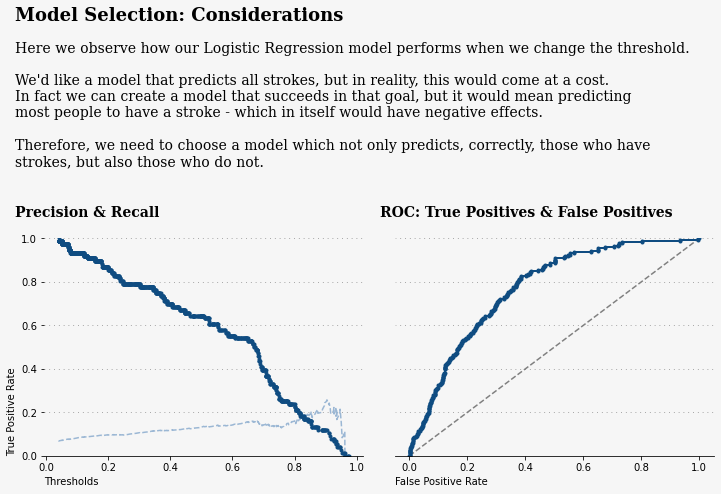

In [38]:
# source code: https://www.kaggle.com/ilyapozdnyakov/rain-in-australia-precision-recall-curves-viz
# heeavily modified plotting

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve

ns_probs = [0 for _ in range(len(y_test))]
lr_probs = logreg_pipeline.predict_proba(X_test)
lr_probs = lr_probs[:, 1]
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)



y_scores = logreg_pipeline.predict_proba(X_train)[:,1]
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)



# Plots

fig = plt.figure(figsize=(12,4))
gs = fig.add_gridspec(1,2, wspace=0.1,hspace=0)
ax = gs.subplots()

background_color = "#f6f6f6"
fig.patch.set_facecolor(background_color) # figure background color
ax[0].set_facecolor(background_color) 
ax[1].set_facecolor(background_color)

ax[0].grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax[1].grid(color='gray', linestyle=':', axis='y',  dashes=(1,5))



y_scores = logreg_pipeline.predict_proba(X_train)[:,1]


precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

ax[0].plot(thresholds, precisions[:-1], 'b--', label='Precision',color='#9bb7d4')
ax[0].plot(thresholds, recalls[:-1], '.', linewidth=1,label='Recall',color='#0f4c81')
ax[0].set_ylabel('True Positive Rate',loc='bottom')
ax[0].set_xlabel('Thresholds',loc='left')
#plt.legend(loc='center left')
ax[0].set_ylim([0,1])


# plot the roc curve for the model
ax[1].plot(ns_fpr, ns_tpr, linestyle='--', label='Dummy Classifer',color='gray')
ax[1].plot(lr_fpr, lr_tpr, marker='.', linewidth=2,color='#0f4c81')
ax[1].set_xlabel('False Positive Rate',loc='left')
ax[1].set_ylabel('')
ax[1].set_ylim([0,1])

for s in ["top","right","left"]:
    ax[0].spines[s].set_visible(False)
    ax[1].spines[s].set_visible(False)
    
    
ax[0].text(-0.1,2,'Model Selection: Considerations',fontsize=18,fontfamily='serif',fontweight='bold')
ax[0].text(-0.1,1.26,
'''
Here we observe how our Logistic Regression model performs when we change the threshold.

We'd like a model that predicts all strokes, but in reality, this would come at a cost.
In fact we can create a model that succeeds in that goal, but it would mean predicting
most people to have a stroke - which in itself would have negative effects.

Therefore, we need to choose a model which not only predicts, correctly, those who have
strokes, but also those who do not.
''',fontsize=14,fontfamily='serif')


ax[0].text(-0.1,1.1,'Precision & Recall',fontsize=14,fontfamily='serif',fontweight='bold')
ax[1].text(-0.1,1.1,'ROC: True Positives & False Positives',fontsize=14,fontfamily='serif',fontweight='bold')

ax[1].tick_params(axis='y', colors=background_color)

plt.show()

### Optimize parameters in SVM

In [39]:
##defining parameter range 
svm_param_grid = {'C': [0.1, 1, 10, 100, 1000],  
             'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
             'kernel': ['rbf']} 

svm = SVC(random_state=42)

grid = GridSearchCV(svm,svm_param_grid)


In [40]:
grid.fit(X_train_resh,y_train_resh)

GridSearchCV(estimator=SVC(random_state=42),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']})

In [41]:
# grid.best_params_

# output:
# {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}

In [42]:
# Let's use those params now

svm_pipeline = Pipeline(steps = [('scale',StandardScaler()),('SVM',SVC(C=1000,gamma=0.01,kernel='rbf',random_state=42))])

svm_pipeline.fit(X_train_resh,y_train_resh)

svm_tuned_pred   = svm_pipeline.predict(X_test)

In [43]:
print(classification_report(y_test,svm_tuned_pred))

print('Accuracy Score: ',accuracy_score(y_test,svm_tuned_pred))
print('F1 Score: ',f1_score(y_test,svm_tuned_pred))

              precision    recall  f1-score   support

           0       0.96      0.79      0.87      3404
           1       0.09      0.41      0.15       173

    accuracy                           0.77      3577
   macro avg       0.53      0.60      0.51      3577
weighted avg       0.92      0.77      0.83      3577

Accuracy Score:  0.7688006709533128
F1 Score:  0.14654282765737872



The tuned Random Forest gave us a much higher accuracy score of around 94%, but with a recall for Stroke patients of 2%. 

The original model had an accuracy of 88%, but a recall for stroke patients of 24%.

This is often where domain knowledge comes in to play. 

In my opinion, the model is better off predicting those who will suffer a stroke, rather than predicting who will not. 



In [44]:
# Make dataframes to plot

rf_df = pd.DataFrame(data=[f1_score(y_test,rf_pred),accuracy_score(y_test, rf_pred), recall_score(y_test, rf_pred),
                   precision_score(y_test, rf_pred), roc_auc_score(y_test, rf_pred)], 
             columns=['Random Forest Score'],
             index=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])

svm_df = pd.DataFrame(data=[f1_score(y_test,svm_pred),accuracy_score(y_test, svm_pred), recall_score(y_test, svm_pred),
                   precision_score(y_test, svm_pred), roc_auc_score(y_test, svm_pred)], 
             columns=['Support Vector Machine (SVM) Score'],
             index=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])

lr_df = pd.DataFrame(data=[f1_score(y_test,logreg_tuned_pred),accuracy_score(y_test, logreg_tuned_pred), recall_score(y_test, logreg_tuned_pred),
                   precision_score(y_test, logreg_tuned_pred), roc_auc_score(y_test, logreg_tuned_pred)], 
             columns=['Tuned Logistic Regression Score'],
             index=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])



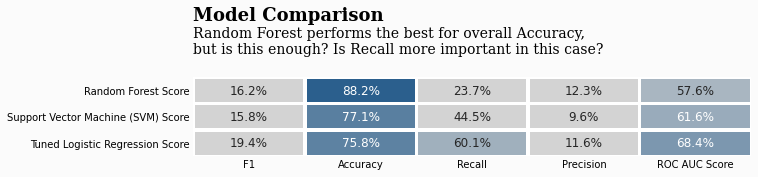

In [45]:
df_models = round(pd.concat([rf_df,svm_df,lr_df], axis=1),3)
import matplotlib
colors = ["lightgray","lightgray","#0f4c81"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

background_color = "#fbfbfb"

fig = plt.figure(figsize=(10,8)) # create figure
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])

sns.heatmap(df_models.T, cmap=colormap,annot=True,fmt=".1%",vmin=0,vmax=0.95, linewidths=2.5,cbar=False,ax=ax0,annot_kws={"fontsize":12})
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) 

ax0.text(0,-2.15,'Model Comparison',fontsize=18,fontweight='bold',fontfamily='serif')
ax0.text(0,-0.9,'Random Forest performs the best for overall Accuracy,\nbut is this enough? Is Recall more important in this case?',fontsize=14,fontfamily='serif')
ax0.tick_params(axis=u'both', which=u'both',length=0)


plt.show()

### Model by Model Confusion Matrix

Now we have selected our models, we can view how they performed in each prediction.

A great way to visualise where your data performs well, and where it performs poorly.





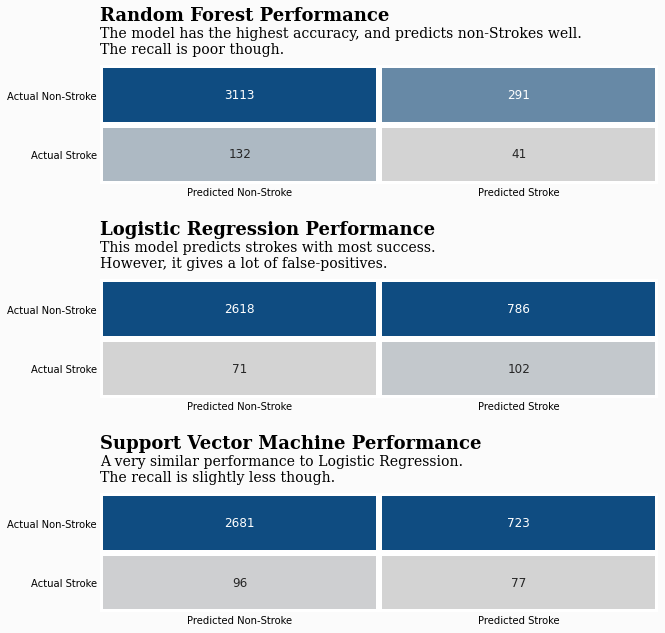

In [46]:

# Plotting our results

colors = ["lightgray","#0f4c81","#0f4c81","#0f4c81","#0f4c81","#0f4c81","#0f4c81","#0f4c81"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)


background_color = "#fbfbfb"

fig = plt.figure(figsize=(10,14)) # create figure
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.1, hspace=0.8)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, :])
ax2 = fig.add_subplot(gs[2, :])
ax0.set_facecolor(background_color) # axes background color

# Overall
sns.heatmap(rf_cm, cmap=colormap,annot=True,fmt="d", linewidths=5,cbar=False,ax=ax0,
            yticklabels=['Actual Non-Stroke','Actual Stroke'],xticklabels=['Predicted Non-Stroke','Predicted Stroke'],annot_kws={"fontsize":12})

sns.heatmap(logreg_cm, cmap=colormap,annot=True,fmt="d", linewidths=5,cbar=False,ax=ax1,
            yticklabels=['Actual Non-Stroke','Actual Stroke'],xticklabels=['Predicted Non-Stroke','Predicted Stroke'],annot_kws={"fontsize":12})

sns.heatmap(svm_cm, cmap=colormap,annot=True,fmt="d", linewidths=5,cbar=False,ax=ax2,
            yticklabels=['Actual Non-Stroke','Actual Stroke'],xticklabels=['Predicted Non-Stroke','Predicted Stroke'],annot_kws={"fontsize":12})



ax0.tick_params(axis=u'both', which=u'both',length=0)
background_color = "#fbfbfb"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) 
ax1.tick_params(axis=u'both', which=u'both',length=0)
ax1.set_facecolor(background_color) 
ax2.tick_params(axis=u'both', which=u'both',length=0)
ax2.set_facecolor(background_color)

ax0.text(0,-0.75,'Random Forest Performance',fontsize=18,fontweight='bold',fontfamily='serif')
ax0.text(0,-0.2,'The model has the highest accuracy, and predicts non-Strokes well.\nThe recall is poor though.',fontsize=14,fontfamily='serif')

ax1.text(0,-0.75,'Logistic Regression Performance',fontsize=18,fontweight='bold',fontfamily='serif')
ax1.text(0,-0.2,'This model predicts strokes with most success.\nHowever, it gives a lot of false-positives.',fontsize=14,fontfamily='serif')

ax2.text(0,-0.75,'Support Vector Machine Performance',fontsize=18,fontweight='bold',fontfamily='serif')
ax2.text(0,-0.2,'A very similar performance to Logistic Regression.\nThe recall is slightly less though.',fontsize=14,fontfamily='serif')


plt.show()

## Model Results Analysis

So all of our models have quite a high accuracy, the highest being 95% (Tuned Random Forest).

But the recall of Strokes is quite poor across the board.

Results always need to be considered carefully - ask yourself: 'Why do I need to predict this value?'
In our case, I would assume it would be to offer medical advice / preventative treatment to those we predict will have a stroke, therefore, in the real-world, I would probably select the model with the highest recall.


The model's can be considered a success - that is, healthcare professionals would be better equipped with this model than without it.


Seeing as Random Forest did have the highest accuracy, I will delve deeper in to the model and how it works - woth feature importance & LIME.

However, the actual selection of model would be up for debate due to the recall variance. 


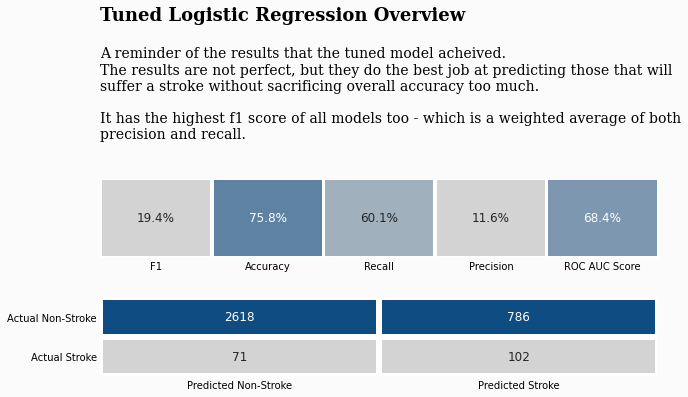

In [47]:
colors = ["lightgray","lightgray","#0f4c81"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

background_color = "#fbfbfb"

fig = plt.figure(figsize=(10,8)) # create figure
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, :])

sns.heatmap(lr_df.T, cmap=colormap,annot=True,fmt=".1%",vmin=0,vmax=0.95,yticklabels='', linewidths=2.5,cbar=False,ax=ax0,annot_kws={"fontsize":12})
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) 
ax1.set_facecolor(background_color) 

ax0.text(0,-2,'Tuned Logistic Regression Overview',fontsize=18,fontweight='bold',fontfamily='serif')
ax0.text(0,-0.3,
'''
A reminder of the results that the tuned model acheived.
The results are not perfect, but they do the best job at predicting those that will
suffer a stroke without sacrificing overall accuracy too much.

It has the highest f1 score of all models too - which is a weighted average of both
precision and recall.
''',fontsize=14,fontfamily='serif')
ax0.tick_params(axis=u'both', which=u'both',length=0)



# Overall

sns.heatmap(logreg_cm, cmap=colormap,annot=True,fmt="d", linewidths=5,cbar=False,ax=ax1,
            yticklabels=['Actual Non-Stroke','Actual Stroke'],vmax=500,vmin=0,xticklabels=['Predicted Non-Stroke','Predicted Stroke'],annot_kws={"fontsize":12})
ax0.tick_params(axis=u'both', which=u'both',length=0)
ax1.tick_params(axis=u'both', which=u'both',length=0)
plt.show()

## Model Interpretation

I'll use some valuable tools which help to uncover the supposed "Black Box" of machine learning algorithms.

As I always say, the models we create need to be sold to business stakeholders. And if business stakeholders don't understand what we're creating, they may be less likely to back the project.

### Dive in to Random Forest's performance

As the model with the highest 'accuracy' (not the best metric for this project), I thought I would include a little more analysis so we can see how the Random Forest makes its predictions.

In [48]:

def rf_feat_importance(m, df):
    return pd.DataFrame({'Feature':df.columns, 'Importance':m.feature_importances_}).sort_values('Importance', ascending=False)


fi = rf_feat_importance(rf_pipeline['RF'], X)
fi[:10].style.background_gradient(cmap=colormap)

,Feature,Importance
1,age,0.403595
6,bmi,0.213655
5,avg_glucose_level,0.197928
4,work_type,0.086557
0,gender,0.062079
2,hypertension,0.023909
3,heart_disease,0.012277


Let's plot this with the top 3 features highlighted.

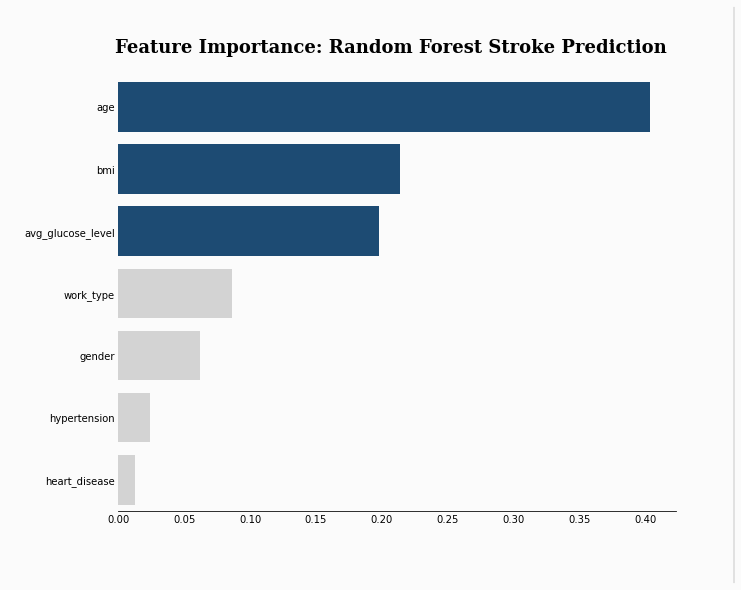

In [49]:
background_color = "#fbfbfb"

fig, ax = plt.subplots(1,1, figsize=(10, 8),facecolor=background_color)

color_map = ['lightgray' for _ in range(10)]
color_map[0] = color_map[1] = color_map[2] =  '#0f4c81' # color highlight

sns.barplot(data=fi,x='Importance',y='Feature',ax=ax,palette=color_map)
ax.set_facecolor(background_color) 
for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
    
fig.text(0.12,0.92,"Feature Importance: Random Forest Stroke Prediction", fontsize=18, fontweight='bold', fontfamily='serif')

    
plt.xlabel(" ", fontsize=12, fontweight='light', fontfamily='serif',loc='left',y=-1.5)
plt.ylabel(" ", fontsize=12, fontweight='light', fontfamily='serif')


ax.tick_params(axis=u'both', which=u'both',length=0)

import matplotlib.lines as lines
l1 = lines.Line2D([0.98, 0.98], [0, 1], transform=fig.transFigure, figure=fig,color='black',lw=0.2)
fig.lines.extend([l1])


plt.show()

It is always interesting to view what features
a predictive model utilises the most, that is, 
what features are the most important. 
This not only helps understand how the model
works, but importantly can help us to explain
the model results.

In this case, we see that Age, Average Glucose Level,
and BMI are the most important factors for our model.

One also notices just how important Age is for our model,
it is by far the most significant variable.

It is also interesting that Work Type is more salient
than Gender - this is a surprise.

Having a history of Heart Disease and Hypertension
are also low in the importance ranking which again
is very surprising.

## SHAP Analysis

SHAP Values (SHapley Additive exPlanations) break down a prediction to show the impact of each feature. 

It interprets the impact of having a certain value for a given feature in comparison to the prediction we'd make if that feature took some baseline value (e.g. zero)


In this case I will use it for the Random Forest Model. It can be used for any type of model but it is by far the quickest with tree based models.

It is possible to change the colour values in SHAP plots too


In [50]:
# great resource: https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values
import shap  

explainer = shap.TreeExplainer(rfc)

# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(X_test)


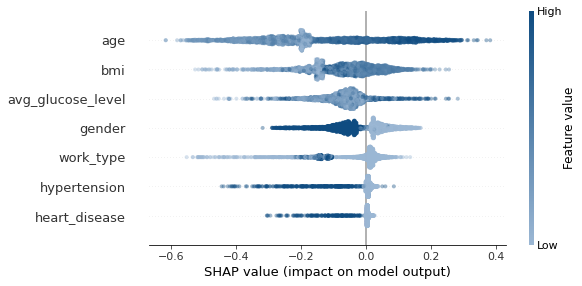

In [51]:
# custom colour plot
colors = ["#9bb7d4", "#0f4c81"]           
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
shap.summary_plot(shap_values[1], X_test,cmap=cmap,alpha=0.4)


### Explanation

The plot above shows the effext of each data point on our predictions. 

For example, for age, the top left point reduced the prediction by 0.6.

The color shows whether that feature was high or low for that row of the dataset
Horizontal location shows whether the effect of that value caused a higher or lower prediction.


We can also see how our Random Forest Model is heavily skewed in favour of predicting no-strokes.



### SHAP dependence plots

We can also focus on how the impact of each variable changes, as the variable itself changes.

For instance, Age. When this variable increases, the SHAP value also increases - pushing the patient closer to  our 1 condition (stroke). 

This is also shown with colour -  pink/red representing those who suffered a stroke.

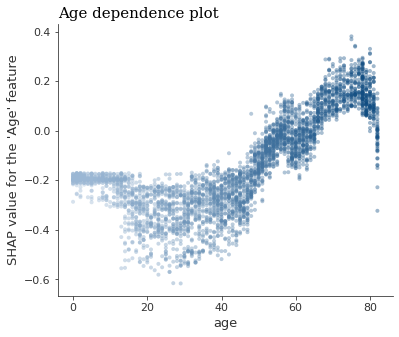

In [52]:

shap.dependence_plot('age', shap_values[1], X_test, interaction_index="age",cmap=cmap,alpha=0.4,show=False)
plt.title("Age dependence plot",loc='left',fontfamily='serif',fontsize=15)
plt.ylabel("SHAP value for the 'Age' feature")
plt.show()

The same plot, but with a more interesting varibale. 

Here we see a clear cutoff point for when strokes become far more common - after a BMI of around 30 or so.

Such is the power of SHAP visualization.

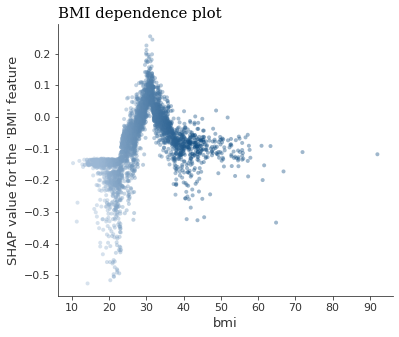

In [53]:
shap.dependence_plot('bmi', shap_values[1], X_test, interaction_index="bmi",cmap=cmap,alpha=0.4,show=False)
plt.title("BMI dependence plot",loc='left',fontfamily='serif',fontsize=15)
plt.ylabel("SHAP value for the 'BMI' feature")
plt.show()

## Use ELI5 for feature explanation

ELI5 stands for Explain it like I am 5 - a quirky name!

Here we see the coefficient for each variable - in other words, what our Logistic model puts most value in.

In [54]:
import eli5

columns_ = ['gender', 'age', 'hypertension', 'heart_disease', 'work_type',
       'avg_glucose_level', 'bmi']

eli5.show_weights(logreg_pipeline.named_steps["LR"], feature_names=columns_)

Weight?,Feature
+1.988,age
+0.231,bmi
+0.195,avg_glucose_level
-0.264,heart_disease
-0.367,work_type
-0.401,<BIAS>
-0.440,hypertension
-0.766,gender


## Conclusion

We started by exploring our data and noticed that certain features, such as Age, looked to be good indicators for predicting a stroke.

After extensive visualization, we went on to try multiple models.

Random Forest, SVM, and Logistic Regression were all tried. 

I then tried hyperparameter tuning on all models to see if I could improve their results.

While Random Fornegative had the highest accuracy, the Tuned Logistic Regression model provided the best recall and f1 score.

Therefore, I selected the Tuned Logistic Regression as my model**.

However I wasn't done. To try to understand how Random Forest was using our data to get the highest accuracy score we looked at feature importance. I also introduced SHAP. This can be useful in understanding how models make predictions, and also where they might be going wrong. 

Finally, I used ELI5 on our chosen Logistic Regression model to show how the features interact with one another to produce a final prediction in the model. 


## References
1. Christoph Molnar, 2022-11-30. [Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/).
2. Sckit learn offcial documentation
3. [Stroke Prediction: Effect of Data Leakage | SMOTE](https://www.kaggle.com/code/tanmay111999/stroke-prediction-effect-of-data-leakage-smote)
4. [Stroke Dataset - EDA and Prediction](https://www.kaggle.com/code/pavithraeskay/stroke-dataset-eda-and-prediction)
5. [Brain Stroke Analysis & Accuracy 96.03%](https://www.kaggle.com/code/hasibalmuzdadid/brain-stroke-analysis-accuracy-96-03)

The shap values and model interpretability are from Interpretable Machine Learning book. It can be found in Chapter 3 and Chapter 9. Official books link are refered. The algorithms were referred directly from the Sckit learn official documentation. The three notebooks are use to think and how could I do my notebook. The remaining code was written independently. Feature importance reference is taken from eli5 offical documnetation. 

The MIT License (MIT)
=====================

Copyright © `<2022>` `<Chao Yan>`

Permission is hereby granted, free of charge, to any person
obtaining a copy of this software and associated documentation
files (the “Software”), to deal in the Software without
restriction, including without limitation the rights to use,
copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the
Software is furnished to do so, subject to the following
conditions:

The above copyright notice and this permission notice shall be
included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES
OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT
HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY,
WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR
OTHER DEALINGS IN THE SOFTWARE.
